# Proximal Gradient Methods for Non-Smooth, Convex Optimization

Proximal gradient methods with backtracking or acceleration are applied to the Lasso problem and the Elastic net problem.

In [1]:
import numpy as np

from pdb import set_trace

import matplotlib.pyplot as plt
%matplotlib inline 

## Algorithms 

In [2]:
# Soft Thresholding function
def soft(z, lam): 
    d = np.shape(z)[0]
    s = np.zeros(d)
    for i in range(d):
        if z[i] > lam:
            s[i] = z[i] - lam
        elif z[i] < -lam:
            s[i] = z[i] + lam
    return s

In [3]:
# Function that computes proximal gradient 
def pgf(z, lam, mu, grad):
    '''
    Input: 
        z:    Location 
        grad: Gradient   
        lam:  Regularization parameter
        mu:   Step size parameter 
        
    Output: 
        pgrad: Proximal Gradient  
    ''' 
    
    ##TODO: Implement proximal gradient computation
    
    ## ( x_k -  prox_{mu * l1 norm} (z - \mu grad) )/ mu
    G = ( z - soft(z - mu*grad, mu*lam) ) / mu
    return G

In [4]:
# Implementation of Proximal Gradient Descent function
def PGD(x0, gf, mu, lam = 0, fun=lambda z: 0, niter=100, eps=1e-6):    
    '''
    Input: 
        x0: intilalization 
        gf: gradient function takes position argument 
        mu:  step size
        lam: regularization parameter
        fun: user defined function (e.g objective function)
        niter: Number of iterations 
        
    Output: 
        z: final solution 
        out: objective values per iterations 
    '''
    out = np.empty(niter+1)
    z = x0.copy() 
    out[0] = fun(z)
    for itr in range(niter):
    # proximal gradient method  
        z = z - mu*pgf(z, lam, mu, gf(z))
        out[itr+1] = fun(z)
        if (np.abs(out[itr+1] - out[itr])/np.abs(out[itr]) <= eps):
            return z, out[:itr+2]
    return z, out

In [5]:
def backtrack(z, f, grad, mu, lam, alp = 2, beta = 0.5):
    
    '''
    Input: 
        z:     Current location
        f:     Differentialable part of fective function 
        grad:  Gradient 
        alp:   Warm start parameter
        beta:  Step size decay parameter 
        mu:    Step size from previous iteration
        lam:   Regularization parameter

    Output: 
        mu: step size 
    '''    
    # backtracking

    # proximal gradient
    G = pgf(z, lam, mu, grad)
    # next point
    T = z - mu*G
    while (f(T) - ( f(z) - mu * np.dot(grad,G) + 0.5*mu*np.dot(G,G) ) >= 0):
        mu *= beta
        G = pgf(z, lam, mu, grad)
        T = z - mu*G
    return mu 

In [6]:
# Implementation of Proximal Gradient Descent function with backtracking line search
def BPGD(x0, gf, lam = 0, f= lambda z: 0, fun=lambda z: 0, niter=100,eps=1e-6):    
    '''
    Input: 
        x0:  intilalization 
        gf:  gradient function takes position argument 
        lam: regularization parameter
        f:   differentiable part of objective function
        fun: user defined function (e.g objective function)
        niter: Number of iterations 

    Itermediate: 
        grad: Gradient
        mu:  step size        
    Output: 
        z: final solution 
        out: objective values per iterations 
    '''
    out = np.empty(niter+1)
    z = x0.copy() 
    mu = 1
    out[0] = fun(z)
    for itr in range(niter):
    # proximal gradient descent with backtracking line search

        # backtracking mu
        mu = backtrack(z, fun, gf(z), mu, lam)
        # proximal gradient update
        z = z - mu*pgf(z, lam, mu, gf(z))
        # store function value
        out[itr+1] = fun(z)
        # check if method stabilized
        if np.abs(out[itr+1] - out[itr])/np.abs(out[itr]) <= eps:
            return z, out[:itr+2]
    
    return z,out

In [7]:
# Implementation of Nesterov Accelerated Proximal Gradient Descent with adaptive restart
def APGD(x0, gf, mu, lam = 0, fun=lambda z: 0, niter=100, eps=1e-6):    
    '''
    Input: 
        x0: intilalization 
        gf: gradient function takes position argument 
        mu: step size
        lam: regularization parameter
        fun: user defined function (e.g objective function)
        niter: Number of iterations 

    Itermediate: 
        z_prev: previous location
        t   : Nestorov parameter
        t_prev: previous Nestorov parameter 
        p   : adjusted location 
 
    Output: 
        z: final solution 
        out: objective values per iterations 
    '''
    
    out = np.empty(niter+1)
    z_prev = x0.copy() 
    z = x0.copy()
    p = x0.copy()

    t_prev = 1
    beta = 0
    out[0] = fun(z_prev)
    
    for itr in range(niter):
    # Implementation of accelerated proximal gradient method with adaptive restart 

        # update step
        z_prev = z.copy()
        z = p - mu * pgf(p, lam, mu, gf(p))
        
        # update momentum stepsize
        t = ( 1 + np.sqrt(1+4*t_prev**2) ) / 2
        beta = (t_prev - 1) / t
        t_prev = t
        
        # acceleration step
        p = z + beta * (z - z_prev)
        
        #mu = backtrack(p, fun, gf(p), mu, lam)
   
        # adaptive restart
        if (np.dot(gf(p) , z - z_prev)) > 0:
        #if (fun(z) > fun(z_prev)):
            # reset step parameters
            t_prev = 1
            beta = 0
            p = z.copy()
        
        # update objective function
        out[itr+1] = fun(z)
        
        # check if method stabilized
        if np.abs(out[itr+1] - out[itr])/np.abs(out[itr]) <= eps:
            return z, out[:itr+2]

    return z, out

## Generating Data

In [8]:
#Set random seed 
np.random.seed(0)

m = 200
n = 500
p = 0.3# Sparsity parameter  
sig = 1 # Variance of noise 

A = np.random.normal(0,1,(m,n))# randomly generated matrix
u,s,v = np.linalg.svd(A,full_matrices=False)
s[-1] = 0
A = np.dot(u*s,v) #change the matrix to be ill-conditioned

x = 10*np.random.binomial(1, p, n)*np.random.rand(n) # simulated sparse vector 
e = np.random.normal(0, sig, m) # Gaussian noise


b = np.dot(A,x) + e # The observation

## Using Lasso

Solving lasso $\min_{x} \frac{1}{2}\|Ax-b\|_2^2 + \lambda \|x\|_1$

In [9]:
Niter = 2000 #Maximum Numer of iterations 

ld = 0.002   #Regularization term
objd = lambda z: np.dot(A @ z - b, A @ z - b)/2    # smooth part of the objective function 
obj = lambda z:  np.dot(A @ z - b, A @ z - b)/2 + ld*np.sum(np.abs(z))   # objective function for lasso
gradf = lambda z: A.T @ ( A @ z - b)  # gradient function for the smooth part of the problem
L1 = np.max((np.linalg.eigvals(A @ A.T)))
stepsize = 1/L1 # stepsize


x_ls = np.dot(np.linalg.pinv(A),b) # the least square solution 
x_pgd, out_pgd = PGD(np.ones(n),gf = gradf, mu = stepsize,lam = ld, fun = obj, niter=Niter)
x_bpgd, out_bpgd = BPGD(np.ones(n),gf = gradf, lam = ld, f = objd,fun = obj, niter=Niter)
x_apgd, out_apgd = APGD(np.ones(n),gf = gradf, mu = stepsize, lam = ld, fun = obj,niter=Niter)


print('Number of iteration needed for pgd: {}'.format(len(out_pgd)))
print('Number of iteration needed for bpgd: {}'.format(len(out_bpgd)))
print('Number of iteration needed for apgd: {}'.format(len(out_apgd)))

Number of iteration needed for pgd: 139
Number of iteration needed for bpgd: 112
Number of iteration needed for apgd: 52


In [10]:
# Difference with respect to ground truth 
print('Norm difference beween ground truth and ls: {}'.format(np.linalg.norm(x_ls-x)))
print('Norm difference beween ground truth and pgd: {}'.format(np.linalg.norm(x_pgd-x)))
print('Norm difference beween ground truth and bpgd: {}'.format(np.linalg.norm(x_bpgd-x)))
print('Norm difference beween ground truth and apgd: {}'.format(np.linalg.norm(x_apgd-x)))

Norm difference beween ground truth and ls: 52.33586122558618
Norm difference beween ground truth and pgd: 47.00847814505909
Norm difference beween ground truth and bpgd: 47.00846877763019
Norm difference beween ground truth and apgd: 47.00857566345012


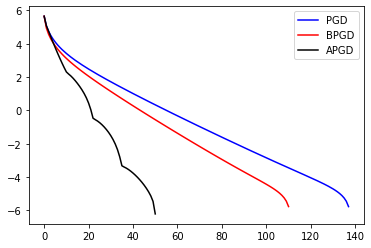

In [11]:
# Converence to the optimal value 
plt.plot(np.arange(len(out_pgd)-1),np.log10(np.array(out_pgd[:-1]-out_pgd[-1])),'b')
plt.plot(np.arange(len(out_bpgd)-1),np.log10(np.array(out_bpgd[:-1]-out_bpgd[-1])),'r')
plt.plot(np.arange(len(out_apgd)-1),np.log10(np.array(out_apgd[:-1]-out_apgd[-1])),'k')

#plt.plot(np.arange(len(out_apgd)-1),np.log10(np.array(out_apgd[:-1]-np.min(out_apgd))),'k')
#plt.plot(np.arange(len(out_hpgd)-1),np.log10(np.array(out_hpgd[:-1]-out_hpgd[-1])),'g')

plt.legend((r'PGD', r'BPGD', r'APGD'), loc = 'upper right')

Evaluate Run Time 

In [12]:
%timeit np.dot(np.linalg.pinv(A),b)

8.48 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
np.random.seed(0)
%timeit x_pgd, out_pgd = PGD(np.ones(n),gf = gradf, mu = stepsize,lam = ld, fun = obj, niter=Niter)

28.5 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
np.random.seed(0)
%timeit x_bpgd, out_bpgd = BPGD(np.random.rand(n),gf = gradf, lam = ld, f = objd,fun = obj, niter=Niter)

59.9 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
np.random.seed(0)
%timeit x_apgd, out_apgd = APGD(np.random.rand(n),gf = gradf, mu = stepsize, lam = ld, fun = obj,niter=Niter)

13.2 ms ± 96.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Elastic Net 

Solving Elastic Net $\min_{x} \frac{1}{2}\|Ax-b\|_2^2 + \lambda_1 \|x\|_2^2 + \lambda_2 \|x\|_1$

In [16]:
Niter = 2000 #Maximum Numer of iterations 

lam1 = 0.0002        ##Regularization term for l2 penalty 
lam2 = 0.002         ##Regularization term ofr l1 penalty 

objd = lambda z: np.dot(A @ z - b, A @ z - b)/2 + lam1 * np.dot(z, z)    # smooth part of the objective function 
obj = lambda z: np.dot(A @ z - b, A @ z - b)/2 + lam1 * np.dot(z, z) + lam2 * np.sum( np.abs(z) )  # objective function for lasso
gradf = lambda z: A.T @ ( A @ z - b) + 2 * lam1 * z   # gradient function for the smooth part of the problem
L2 = np.max(np.abs((np.linalg.eigvals(A.T @ A + 2*lam1*np.identity(n))))) # Lipschitz constant 
stepsize = 1/L2   # stepsize



x_ls = np.dot(np.linalg.pinv(A),b) # the least square solution 
x_pgd, out_pgd = PGD(np.ones(n),gf = gradf, mu = stepsize,lam = lam2, fun = obj, niter=Niter)
x_bpgd, out_bpgd = BPGD(np.ones(n),gf = gradf, lam = lam2, f = objd,fun = obj, niter=Niter)
x_apgd, out_apgd = APGD(np.ones(n),gf = gradf, mu = stepsize, lam = lam2,fun = obj,niter=Niter)


print('Number of iteration needed for pgd: {}'.format(len(out_pgd)))
print('Number of iteration needed for bpgd: {}'.format(len(out_bpgd)))
print('Number of iteration needed for apgd: {}'.format(len(out_apgd)))

Number of iteration needed for pgd: 137
Number of iteration needed for bpgd: 111
Number of iteration needed for apgd: 53


In [17]:
# Difference with respect to ground truth 
print('Norm difference beween ground truth and ls: {}'.format(np.linalg.norm(x_ls-x)))
print('Norm difference beween ground truth and pgd: {}'.format(np.linalg.norm(x_pgd-x)))
print('Norm difference beween ground truth and bpgd: {}'.format(np.linalg.norm(x_bpgd-x)))
print('Norm difference beween ground truth and apgd: {}'.format(np.linalg.norm(x_apgd-x)))

Norm difference beween ground truth and ls: 52.33586122558618
Norm difference beween ground truth and pgd: 47.00858768832531
Norm difference beween ground truth and bpgd: 47.00857657395658
Norm difference beween ground truth and apgd: 47.00864367420152


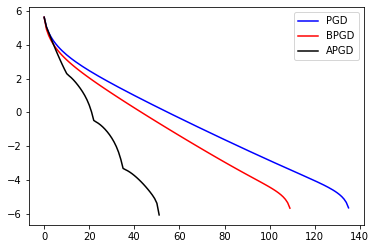

In [18]:
# Converence to the optimal value  in log scale 
plt.plot(np.arange(len(out_pgd)-1),np.log10(np.array(out_pgd[:-1]-out_pgd[-1])),'b')
plt.plot(np.arange(len(out_bpgd)-1),np.log10(np.array(out_bpgd[:-1]-out_bpgd[-1])),'r')
plt.plot(np.arange(len(out_apgd)-1),np.log10(np.array(out_apgd[:-1]-out_apgd[-1])),'k')

plt.legend((r'PGD', r'BPGD', r'APGD'), loc = 'upper right')

Evaluate Run Time

In [27]:
%timeit np.dot(np.linalg.pinv(A),b)

8.59 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
np.random.seed(0)
%timeit x_pgd, out_pgd = PGD(np.ones(n),gf = gradf, mu = stepsize,lam = ld, fun = obj, niter=Niter)

28.1 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
np.random.seed(0)
%timeit x_bpgd, out_bpgd = BPGD(np.random.rand(n),gf = gradf, lam = ld, f = objd,fun = obj, niter=Niter)

58.6 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
np.random.seed(0)
%timeit x_apgd, out_apgd = APGD(np.random.rand(n),gf = gradf, mu = stepsize, lam = ld, fun = obj,niter=Niter)

The slowest run took 9.23 times longer than the fastest. This could mean that an intermediate result is being cached.
78.1 ms ± 40 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
